### Example 5: Using the simple forward model to test TCCON-like retrievals -- Weak CO$_2$ band as example
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________
The purpose of this exercise is to use the simple forward model developed in Example 4 to actually perform retrievals using a synthetic measurement.

This is now going into Bayesian inversion using prior information, for which the Rodgers book is really needed to fully understand it!

Things you will learn (and need to remember) in this and the coming notebooks:
- Prior state $x_a$ and prior covariance matrix $S_a$
- Bayes' theorem, impact of prior knowledge
- Averaging kernel matrix $A$
- Smoothing error
- Forward model error
- Degrees of freedom (DOF)


In [1]:
# using some standard modules here
using Plots          # For Plots
#using DelimitedFiles # For reading text files
using Interpolations # For interpolations
using Polynomials    # Polynomials
using Statistics     # mean, std, etc
using LinearAlgebra  # Linear Algebra 
using NCDatasets     # NetCDF file support
using ForwardDiff
using ImageFiltering
using Interpolations
#using DirectConvolution

Creating a structure to save data conveniently (and pass to functions)

In [2]:
struct fitSetup
    cs_matrix_h2o::Matrix{Float64} 
    cs_matrix_co2::Matrix{Float64}
    cs_matrix_ch4::Matrix{Float64} 
    Io::Vector{Float64}
    FWHM::Float64 
    polyDegree::Int
    SZA::Float64
    nu_in::Vector{Float64} 
    nu_out::Vector{Float64} 
    VCD_dry::Vector{Float64}
    n_layers::Int
end



---
Let us load the precomputed optical properties from before (ideally all in pure Julia but this will take a bit of time still). 
##### Reading in saved HDF5 file from last exercise
This is just a convenient way of re-importing the variables (and I bet you will stumble over HDF5 files at one point in your student life or may now actually think about using this format for saving your own data instead of using an Excel spreadsheet :-)).

In [3]:
# Using the NCDataset tools (note, we used groups and variables while saving)
f = Dataset("files/crossSections_SCO2Band.h5");
nu_ = convert(Vector{Float64},f["wavenumberGrid"][:]);
wo = findall(abs.(nu_.-6225).<50)
nu_ =nu_[wo]
cs_matrix_co2_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_co2"][:]);
cs_matrix_ch4_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_ch4"][:]);
cs_matrix_h2o_ = convert(Matrix{Float64},f.group["CrossSections"]["cs_matrix_h2o"][:]);
VCD_dry = convert(Vector{Float64},f.group["Profiles"]["VCD_dry"][:]);
vmr_h2o = convert(Vector{Float64},f.group["Profiles"]["vmr_h2o"][:]);

Tsolar = convert(Vector{Float64},f["Tsolar"][:]);
Tsolar = Tsolar[wo]
p_full = convert(Vector{Float64},f.group["Profiles"]["p"][:]);

# Change row column order (ignore for now)
s = size(cs_matrix_co2_)
cs_matrix_co2 = zeros((length(wo),s[1]))
cs_matrix_ch4 = similar(cs_matrix_co2)
cs_matrix_h2o = similar(cs_matrix_co2)
for i=1:s[1]
    cs_matrix_co2[:,i]=cs_matrix_co2_[i,wo]
    cs_matrix_ch4[:,i]=cs_matrix_ch4_[i,wo]
    cs_matrix_h2o[:,i]=cs_matrix_h2o_[i,wo]
end

FWHM = 0.05
fs = fitSetup(cs_matrix_h2o,cs_matrix_co2,cs_matrix_ch4,Tsolar, FWHM, 3,45,nu_,nu_[1]:FWHM/3:nu_[end],VCD_dry ,72 );

---
### Defining the state vector $x$:
This might seem a bit clumsy in the beginning but we have to find a way to represent all our target inversion variables in the state vector (the VMRs of all trace gases and some polynomial coefficients). This can (should) of course be done more elegantly (e.g. you can create dictionaries that help match the names of variables to the state vector, etc, so that things can be changed in a flexible way). For now, we are lazy and define our state vector in a rather fixed way (and the forward model currently assumes it to be like that).

In [4]:
n_layers=72
xa = zeros(72*3+3)
xa[1:n_layers].=400e-6              # CO2
xa[1+n_layers:2n_layers].=1800e-9   # CH4
xa[1+2n_layers:3n_layers]= vmr_h2o  # H2O
xa[1+3n_layers:end]=[25,-1e-3,-1e-6];

## Computing Forward model and Jacobian K
What we are trying to do now is to write a function that can evaluate the Forward model but also compute its Jacobian if needed. In principle, one could compute the Jacobian numerically but this would require evaluating the Forward model with a perturbed state vector (one for each) and choosing the right step-size to compute the derivative numerically 
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x)}{\Delta x_i}$$
or better a two-point formula:
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x-\Delta x_i)}{2\Delta x_i}$$

Let's go back to our forward model, which includes the computation of the transmission of the atmosphere along a slant light-path from the sun to the observer on the ground, multiplied with a low-order polynomial to account for any other effect such as scattering in the atmosphere, spectral shape of Black body of solar spectrum, detector sensitivity, etc. (it just bunches up all these effects without a real physical meaning here):
$$F(x) = <I_o\cdot\exp\left(-AMF\cdot\sum_{i=0}^n x_i\cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)\right)\cdot \sum_{i=n+1}^{n+1+polyDegree}x_i\cdot \nu^{i-(n+1)}>$$ 
with $x_{i\dots n}$ being the the $VMRs$ and $x_{i+n\dots n+1+polyDegree}$ the coefficients for the polynomial. The operator $<>$ denotes the instrument operator (instrument line shape ILS), including the convolution of the high resolution transmission and resampling to the detector wavenumber grid:
$$<I>(\nu_1) = \int_{-\infty}^{\infty}I(\nu)\cdot ILS(\nu_1-\nu)d\nu$$
or in its discrete form
$$<I>(\nu_1) = \sum_{\nu=-\nu_1-\Delta}^{\nu_1+\Delta}I(\nu)\cdot ILS(\nu_1-\nu)\,,$$
where we can choose a width $\Delta$ over which the convolution will be applied (typically just the range over which the ILS is finite). The above didn't yet include the resampling to the detector ($y$) grid but this is just an interpolation anyhow (a down-sampling from a higher resolution grid to the actual nmeasurement grid). If the ILS is not changing over the entire fitting range, we can make use of the convolution theorem, which states that under suitable conditions the Fourier transform of a convolution is the pointwise product of Fourier transforms (otherwise, we often need a bute-force convolution, which can cost time). 

What we need to compute as well is the Jacobian Matrix $K$, which is defined as the derivative of the forward model with respect to $x$:

$$K = {dF(x) \over dx} = 
\left\vert\matrix{{\partial F_1(x) \over \partial x_1} & {\dots} & {\partial F_1(x) \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial F_m(x) \over \partial x_1} & {\dots} & {\partial F_m(x) \over \partial x_n}}\right\vert\,.$$

In our simplified forward model, we can actually compute the derivatives analytically. For the state vector elements with a $VMR$, the derivative will be:
$${\partial F(x) \over \partial x_i} = <F(x)\cdot -AMF \cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)>$$

<font color='red'>**Question:**</font> Can you perform this differentiation? 
<font color='red'>**Question:**</font> Can you show how this linearizes $\log(F(x)$ and basically provides the DOAS method if the convolution can be ignored?



---
#### Define F(x):
Let us define the instrument operator as well as the Forward Model here:


In [5]:
# Very simple instrument function here (Gaussian)
function applyInstrument(y,nu_in,nu_out, FWHM)
    co = 2.355
    res = nu_in[2]-nu_in[1]
    y2 = imfilter(y, Kernel.gaussian((FWHM/res/co,)))
    #Gridded(Linear())
    itp = interpolate((nu_in,), y2[:,1], Gridded(Linear()))
    return itp(nu_out)
end

# Simples forward model here (includes linearization):
function TCCON_ForwardMod(x; compK::Bool=false, p::fitSetup=fs)
    total_od_ch4 = similar(p.nu_in)
    total_od_co2 = similar(p.nu_in)
    total_od_h2o = similar(p.nu_in)
    
    pol = x[1+3p.n_layers:end]
    #println(p)
    # Compute Air Mass Factor given SZA
    AMF = 1.0/cos(deg2rad(p.SZA))
    
    # Compute total optical thickness
    total_od_co2 = p.cs_matrix_co2*(p.VCD_dry.*x[1:p.n_layers])
    total_od_ch4 = p.cs_matrix_ch4*(p.VCD_dry.*x[1p.n_layers+1:2p.n_layers])
    total_od_h2o = p.cs_matrix_h2o*(p.VCD_dry.*x[2p.n_layers+1:3p.n_layers])
    
    # Compute transmission
    T  = p.Io.*exp.(-AMF*(total_od_ch4+total_od_co2+total_od_h2o))
    
    # Multiply with our baseline polynomial
    dnu = (p.nu_in.-mean(p.nu_in))
    F = T.*(x[end].*dnu.^2 .+x[end-1].*dnu .+x[end-2])
    
    # Compute Jacobian Matrix K if needed analytically here (will go through this in class):
    if compK
        K = zeros(length(p.nu_out),length(x))
        
        for i=1:72
            K[:,i] = applyInstrument(AMF.*F.*-p.cs_matrix_co2[:,i]*p.VCD_dry[i],p.nu_in, p.nu_out,p.FWHM)
            K[:,i+p.n_layers] = applyInstrument(AMF.*F.*-p.cs_matrix_ch4[:,i]*p.VCD_dry[i],p.nu_in, p.nu_out,p.FWHM)
            K[:,i+2p.n_layers] = applyInstrument(AMF.*F.*-p.cs_matrix_h2o[:,i]*p.VCD_dry[i],p.nu_in, p.nu_out,p.FWHM)
        end
        
        # Polynomials here:
        K[:,3p.n_layers+1] = applyInstrument(T.*dnu.^2,p.nu_in, p.nu_out,p.FWHM);
        K[:,3p.n_layers+2] = applyInstrument(T.*dnu,p.nu_in, p.nu_out,p.FWHM);
        K[:,3p.n_layers+3] = applyInstrument(T,p.nu_in, p.nu_out,p.FWHM);
        return applyInstrument(F,p.nu_in, p.nu_out,p.FWHM), K
    else
        return applyInstrument(F,p.nu_in, p.nu_out,p.FWHM)
    end
end

TCCON_ForwardMod (generic function with 1 method)

---
Let's test running the Forward model (run it a few times and check first occurrence vs. afterwards

In [6]:
@time Fxa = TCCON_ForwardMod(xa);

  2.520886 seconds (10.28 M allocations: 504.517 MiB, 6.76% gc time)


In [7]:
# Let's try to compare our Jacobian calculation as well as our attempt to use auto-derivatives:
@time Fxa,K2 = TCCON_ForwardMod(xa;compK=true);
g = x -> ForwardDiff.jacobian(TCCON_ForwardMod, x);
@time K = g(xa);

  0.161526 seconds (24.48 k allocations: 205.771 MiB, 52.65% gc time)
  2.003366 seconds (7.26 M allocations: 567.697 MiB, 6.27% gc time)


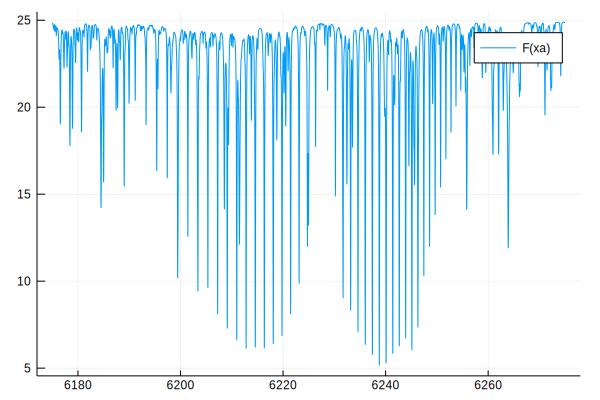

In [8]:
plot(fs.nu_out,Fxa, label="F(xa)")

----
#### Plot a few Jacobians 

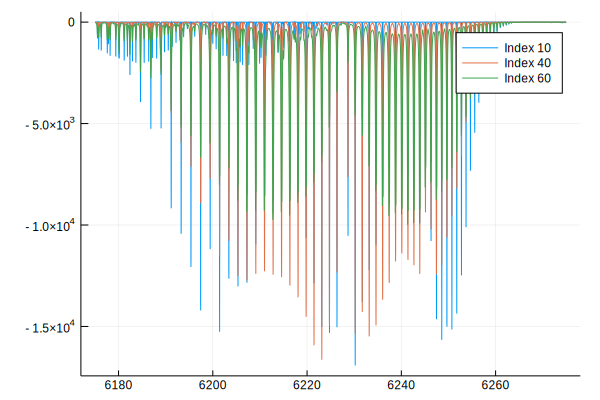

In [9]:
#nu_out=nu_[1]:FWHM/3:nu_[end]
plot(fs.nu_out, K[:,10]/VCD_dry[10]*1e25, label="Index 10")
plot!(fs.nu_out, K[:,40]/VCD_dry[40]*1e25, label="Index 40")
plot!(fs.nu_out, K[:,60]/VCD_dry[60]*1e25, label="Index 60")
#xlims!(6200,6204)

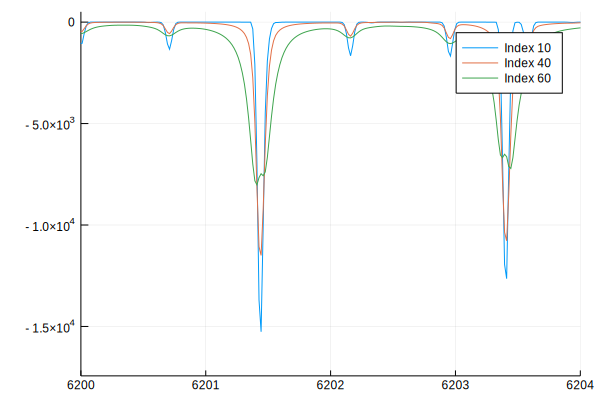

In [10]:
# Zoom:
plot(fs.nu_out, K[:,10]/VCD_dry[10]*1e25, label="Index 10")
plot!(fs.nu_out, K[:,40]/VCD_dry[40]*1e25, label="Index 40")
plot!(fs.nu_out, K[:,60]/VCD_dry[60]*1e25, label="Index 60")
xlims!(6200,6204)

--- 
### Perturbing the forward model
What we can do now is change the state vector at a particular layer (like a small perturbation in the VMR of a trace gas at one specific layer only) and add some noise to it. Here, we just add 50ppm of CO2 into a couple of layers close to the surface and see how the retrieval will react. 

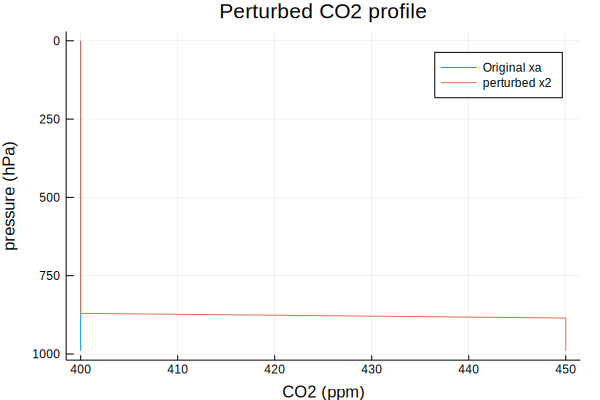

In [11]:
# Which index to change (arbitrary choice here, used 65 here, and everything below)
index = 65
x2 = copy(xa)
dx = 50e-6

# Perturb by 50ppm
x2[index:72] = xa[index:72].+dx

plot(xa[1:72]*1e6, p_full,yflip=true, label="Original xa"  )
plot!(x2[1:72]*1e6, p_full, label="perturbed x2"  )
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")
title!("Perturbed CO2 profile")

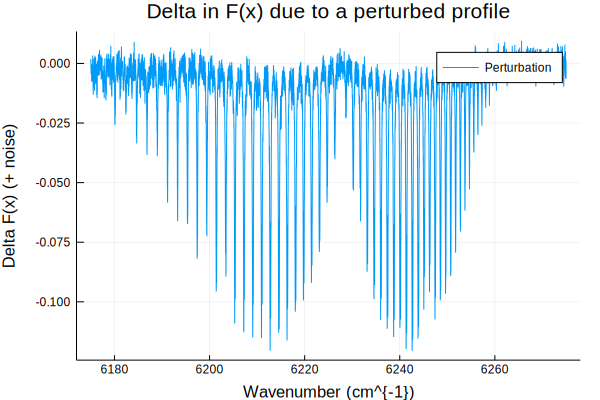

In [12]:
# Assume some noise level (fixed values across the entire range here)

# Note, this is an incredibly high SNR value, around 6000 in the continuum amd 1500 in the line center!
noise = 0.003
ϵ = randn(length(fs.nu_out)).*noise
F2 = TCCON_ForwardMod(x2).+ϵ
plot(fs.nu_out, ((F2-Fxa)), label="Perturbation")
xlabel!("Wavenumber (cm^{-1})")
ylabel!("Delta F(x) (+ noise)")
title!("Delta in F(x) due to a perturbed profile")

# Naive fitting

#### Perturbing the forward model nearby our known state
Before we move on to fully non-linear retrievals, we assume for now that the model behaves linearly around the state we are looking at if the changes are small. This way, we can still perform a linear retrieval as described before, but just doing:
$$y-F(x)=K\cdot\Delta x$$
where we now retrieved the $\Delta$ in the state vector from the state that we used to compute $F(x)$. This way, we can use the same normal equations to solve the above.

In [13]:
# Define Se again
Se = Diagonal((ones(length(fs.nu_out)).*noise).^2);

In [14]:
# Perfom linear least squares:
@time delta_x = inv(K'inv(Se)*K)K'inv(Se)*(F2-Fxa);

  0.690534 seconds (2.58 M allocations: 156.252 MiB, 7.74% gc time)


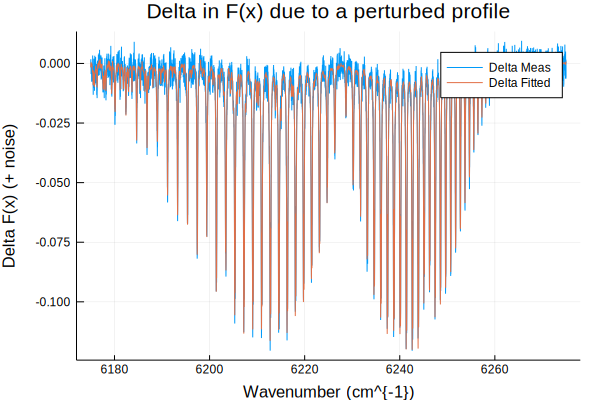

In [15]:
# Plot fit:
plot(fs.nu_out, ((F2-Fxa)), label="Delta Meas")
plot!(fs.nu_out, K*delta_x, label="Delta Fitted")
xlabel!("Wavenumber (cm^{-1})")
ylabel!("Delta F(x) (+ noise)")
title!("Delta in F(x) due to a perturbed profile")

### Fitted state vector
Let's look at the fitted state vector now, the spectral fit looked pretty ok, how did the state vector work out?

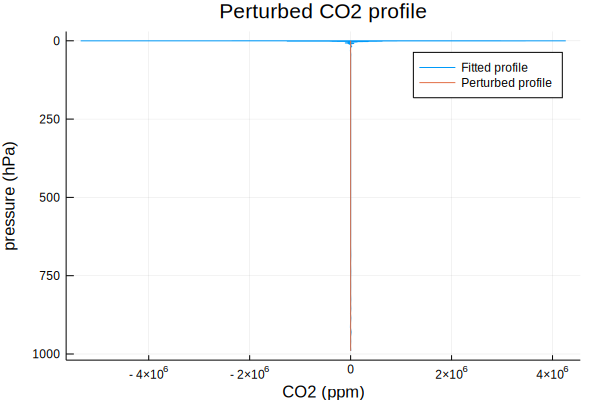

In [16]:
plot((xa[1:72]+delta_x[1:72])*1e6, p_full,yflip=true, label="Fitted profile"  )
plot!(x2[1:72]*1e6, p_full, label="Perturbed profile"  )
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")
title!("Perturbed CO2 profile")


Well, that looks weird, let's zoom in:

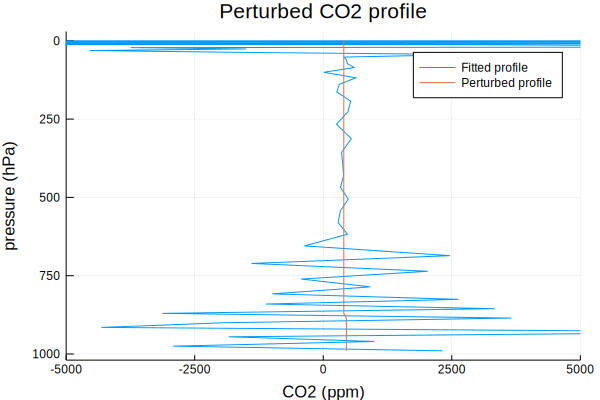

In [17]:
plot((xa[1:72]+delta_x[1:72])*1e6, p_full,yflip=true, label="Fitted profile"  )
plot!(x2[1:72]*1e6, p_full, label="Perturbed profile"  )
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")
title!("Perturbed CO2 profile")
xlims!((-5000,5000))

---
## Why is this so bad?
Ok, this simple inversion was really bad and messed up the retrieved state vector with many unphysical values. 

Why did this happen and how can we salvage this? The inversion is unstable (not enough information to solve the state vector) and we need to regularize the problem, a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting. There are different ways of doing this but for now, we will focus on using actual prior information and the Bayes Theorem (see Rodger's, pages 22ff):
$$P(x|y) = \frac{P(y|x)P(x)}{P(y)}$$

Using Gaussian uncertainties, we can express mismatches in the measurement space as well as the state vector space, if we assume some prior knowledge as to how the state vector "should" behave, characterized by it's prior $x_a$ (mean expected state) as well as its variance-covariance matrix $S_a$:
$$-2\ln P(y|x) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx)+c_1$$
and 
$$-2\ln P(x) =  (x-x_a)^T S_{a}^{-1}(x-x_a)+c_2\,,$$
with the prior covariance matrix $S_a$ representing the expected value 
$$S_a = \mathbf{E}\left((x-x_a)(x-x_a)^T\right)$$

If we assume $P(y)$ to just be a normalising factor, we can rewrite $-2\ln P(x|y)$ as
$$-2\ln P(x|y) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx) + (x-x_a)^T S_{a}^{-1}(x-x_a) + c_3$$

If we want to maximize $P(x|y)$, we just have to minimize the right hand side of the equation, which is almost exactly the same we found for the normal least squares approach apart from the added cost function induced by our prior knowledge: $(x-x_a)^T S_{a}^{-1}(x-x_a)$. 

As shown in Rodgers, the retrieved state vector $\hat{x}$ is now:
$$\hat{x} = x_a + (K^TS_\epsilon^{-1}K+S_a^{-1})^{-1}K^TS_\epsilon^{-1}(y-Kx_a)\,$$
for which we can replace $Kx_a$ with $F(x_a)$ as done in our case. 

What can we use as prior information for the CO$_2$ mixing ratio now? We know that it is a long-lived gas and its variations are rather small, with an overall seasonal amplitude of only 10-20ppm (around a background of 400ppm). We also know that changes in its concentrations are usually coorelated in between nearby atmospheric layers (vertically). So we could construct some covariance matrix based on a fixede relative percentage on the diagonal but adding correlations on the off-diagonal (feel free to play around!). 

In the example below, we just assume a 10% uncertainty on the diagonal and then multiply the variances with a exp(-dp/100) factor, which provides a correlation as a function of pressure difference between layers (one could use real model data to try to generate a proper covariance matrix but here we use just this). 

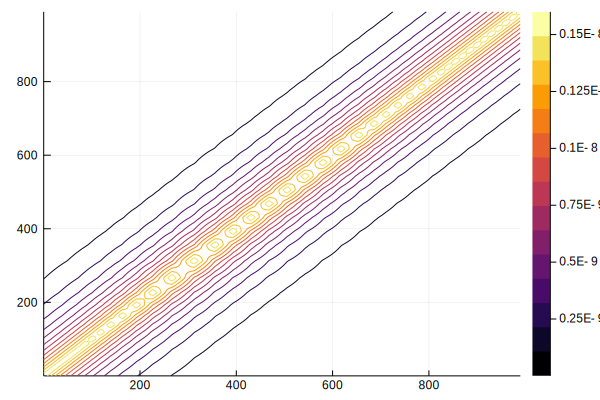

In [18]:
# Add prior information:
Sa = zeros((length(xa),length(xa)))

# Say we have a 10% uncertainty for all prior trace gas concentrations:
for i=1:fs.n_layers*3 
    Sa[i,i]=(0.10*xa[i])^2
end

# Now let's do CO2 with off-diagonals:
for i=1:72
    Sa[i,i]=(0.1*xa[i])^2
    for j=1:72
        dp = abs(p_full[i]-p_full[j])
        Sa[i,j]=Sa[i,i]*exp(-dp/100.) # *0.9999#
        Sa[j,i]=Sa[i,i]*exp(-dp/100.) # *0.9999#
    end
end
# For the polynomials
Sa[3fs.n_layers+1,3fs.n_layers+1]=10^2
Sa[3fs.n_layers+2,3fs.n_layers+2]=1e-2^2
Sa[3fs.n_layers+3,3fs.n_layers+3]=1e-3^2
contour(p_full, p_full, Sa[1:72,1:72])
#plt.title('Prior Covariance Matrix (just the CO$_2$ profile elements)')
#plt.colorbar()

---
## Computing Posterior error covariance, Gain matrix and Averaging Kernel:
We can compute the Gain matrix and posterior error covariance as before, just with $\hat{S}^{-1}$ now being
$$\hat{S}^{-1} = K^TS_\epsilon^{-1}K+S_a^{-1}\,$$
(see Rodgers).

We can also compute the Averaging Kernel Matrix $A$,
$$AK = {\partial \hat{x} \over \partial x} = GK$$
This can be seen as $\Delta F(x)$ is $K(x-x_a)+\epsilon$, thus
$$\hat{x} = G[K(x-x_a)+\epsilon] = GK(x-x_a)+G\epsilon$$

It is important to fully understand the meaning of the A matrix as it is instrumental in understanding the measurement sensitivity and later comparisons against model data (for instance). The A matrix (nxn) represents the derivative of the retrieved state vector $\hat{x}$ with respect to a true change in the state vector $x$. E.g. we can solve the question what would happen to the state vector if CO$_2$ in reality changes at only one layer at say 800hPa or 300hPa.
$$A = {\partial \hat{x} \over \partial x} = \left\vert\matrix{{\partial \hat{x}_1 \over \partial x_1} & {\dots} & {\partial \hat{x}_1 \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial \hat{x}_n \over \partial x_1} & {\dots} & {\partial \hat{x}_n \over \partial x_n}}\right\vert\,.$$

The rows of the $A$ basically show how a specific retrieved state vector element $\hat{x}_i$ reacts to true changes of the state vector at different positions $x_i$ while the columns of the $A$ show how the overal state vector $\hat{x}$ reacts to a perturbation of the true state in one singular position $x_i$. This is reflected in the columns of the $A$ while the rows reflect the change in the retrieved state vector at particular index $i$ vs. a change in the true state at all other positions. 
In the ideal case, the $A$ would be unity on the diagonal and zero elsewhere, indicating a perfect retrieval.

---

So, let's compute the posterior covariance matrix S^hat, the Gain Matrix G and the Averaging Kernel Matrix A

In [130]:
# Posterior Uncertainty matrix
Ŝ = inv(K'inv(Se)*K+inv(Sa));

# Gain Matrix G
G = Ŝ*K'inv(Se);

# Averaging Kernel Matrix A
A = G*K;

# Column weighting function h
h = zeros(length(xa));
h[1:72] = VCD_dry/sum(VCD_dry);

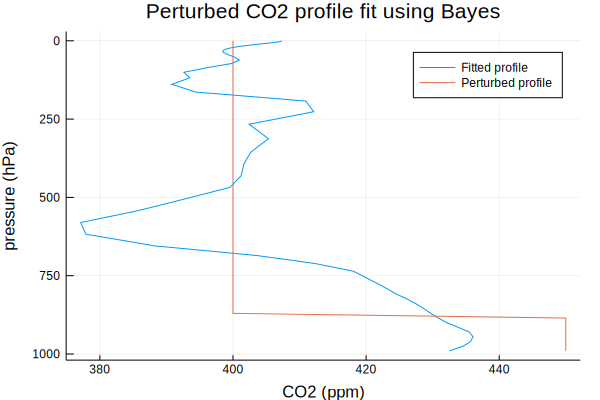

In [20]:
xhat = xa + G*(F2-Fxa)
plot((xhat[1:72])*1e6, p_full,yflip=true, label="Fitted profile"  )
plot!(x2[1:72]*1e6, p_full, label="Perturbed profile"  )
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")
title!("Perturbed CO2 profile fit using Bayes")
#xlims!((-15000,15000))

### Looks much better
doesn't it? Still a bit funky for a first time user I guess. Let us explore whether we actually expect a retrieval like this based on our knowledge of the fit itself (our computed sensitivity).


In [21]:
# Compute model response to noise vector
Geps = G*ϵ;

# Compute A(x_true-x_a)
Ax_xa = A*(x2-xa);


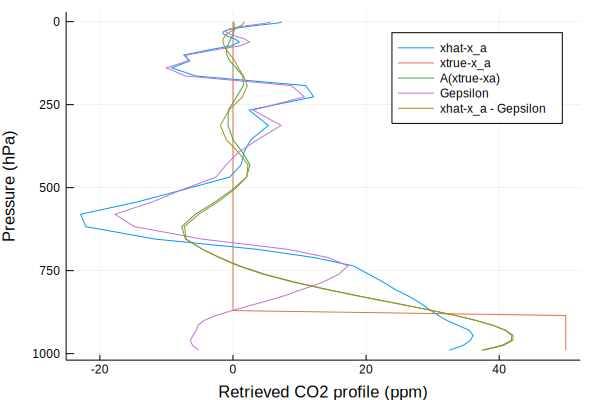

In [38]:
#plt.subplot(211)

plot( 1e6*(xhat[1:72]-xa[1:72]),p_full,yflip=true,label="xhat-x_a")
plot!( 1e6*(x2[1:72]-xa[1:72]),p_full,yflip=true,label="xtrue-x_a")
#plot(1.e6*(x2[0:72]-x[0:72]),pressure,label='True $x-x_a$')
plot!( 1.e6*Ax_xa[1:72],p_full,label="A(xtrue-xa)")
plot!( 1.e6*Geps[1:72],p_full,label="Gepsilon")
plot!( 1e6*(xhat[1:72]-xa[1:72]-Geps[1:72]),p_full,yflip=true,label="xhat-x_a - Gepsilon")
#plot!( 1.e6*Geps[1:72].+1.e6*Ax_xa[1:72],p_full,label="Gepsilon + A(x-xa)")
#plot( 1e6*np.sqrt(np.diag(S[0:72,0:72])),pressure,'--',label='Diagonal of $\hat{S}$')

xlabel!("Retrieved CO2 profile (ppm)")
ylabel!("Pressure (hPa)")
#ylims!((1000,0))



In [34]:
XCO2_uncertainty = sqrt(h'*Ŝ*h)*1e6
XCO2_prior_uncertainty = sqrt(h'*Sa*h)*1e6

println("Prior XCO2 assumption: ", fs.VCD_dry'*xa[1:72]/sum(fs.VCD_dry)*1e6)
println("Fitted Bayes XCO2: ", fs.VCD_dry'*xhat[1:72]/sum(fs.VCD_dry)*1e6)
println("Fitted naive XCO2: ", fs.VCD_dry'*(xa[1:72]+delta_x[1:72])/sum(fs.VCD_dry)*1e6)
println("True XCO2: ", fs.VCD_dry'*x2[1:72]/sum(fs.VCD_dry)*1e6)
println("Uncertainty in XCO2: ", XCO2_uncertainty)
println("Prior Uncertainty in XCO2: ", XCO2_prior_uncertainty)

Prior XCO2 assumption: 400.0
Fitted Bayes XCO2: 405.9426723027747
Fitted naive XCO2: 405.9414729493252
True XCO2: 405.9657906809976
Uncertainty in XCO2: 0.022345618115548242
Prior Uncertainty in XCO2: 17.067050694620086


In [28]:
XCO2_uncertainty = sqrt(h'*Ŝ*h)*1e6

0.022345618115548242

In [77]:
using LaTeXStrings
using Printf

## A closer look at the averaging kernels
<font color='red'>**Question:**</font> What do the rows and columns of the averaging kernel mean (in your own words)? 


---
### Rows of the averaging kernel

The individual rows of the averaging kernel provide the response of the state vector at each position i (colorcoded) to a change in the true state at different locations. Here, we just look at the parts of the averaging kernel related to CO2 only (i.e. index 1-72)

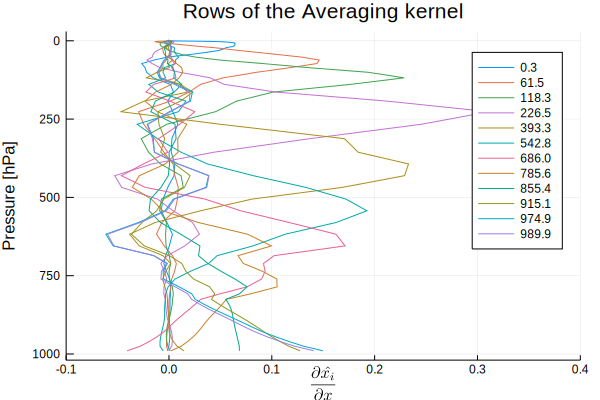

In [106]:
p = plot(A[10,1:72],p_full,yflip=true,label=@sprintf "%3.1f" p_full[10])
for i=35:4:72
    s = @sprintf "%3.1f" p_full[i];
    plot!(A[i,1:72],p_full,label=@sprintf "%3.1f" p_full[i])
end
plot!(A[72,1:72],p_full,label=@sprintf "%3.1f" p_full[72])
p
    #plt.xlim((-0.05,0.25))    
#plt.legend()
#plt.gca().invert_yaxis()
xlabel!(L"\frac{\partial \hat{x_i}}{\partial x}")
ylabel!("Pressure [hPa]")
title!("Rows of the Averaging kernel")
xlims!((-0.1,0.4))

---
### Columns of the averaging kernel

The individual columns of the averaging kernel provide the response of the state vector to an impuls in the true state at index i (colorcoded). Here, we just look at the parts of the averaging kernel related to CO2 only (i.e. index 1-72)

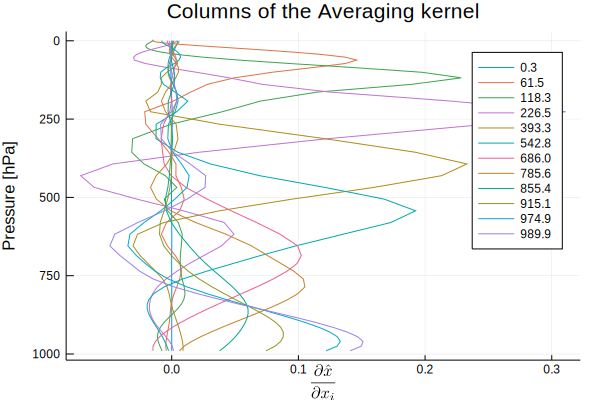

In [159]:
p = plot(A[1:72,10],p_full,yflip=true,label=@sprintf "%3.1f" p_full[10])
for i=35:4:72
    s = @sprintf "%3.1f" p_full[i];
    plot!(A[1:72,i],p_full,label=@sprintf "%3.1f" p_full[i])
end
plot!(A[1:72,72],p_full,label=@sprintf "%3.1f" p_full[72])
p

xlabel!(L"\frac{\partial \hat{x}}{\partial x_i}")
ylabel!("Pressure [hPa]")
title!("Columns of the Averaging kernel")

---
## Degrees of freedom for CO$_2$ profile
The degrees of freedom for signal (DOFs) is a metric for how many independent variables one can actually retrieve. It can be computed at the trace of the averaging kernel matrix. (see e.g. Rodgers, page 54 top)

Here, we can just look at the DOF for the CO2 retrievals (or the other trace gases). The is the trace of the averaging kernel matrix over the CO$_2$ state vector elements:

In [112]:
# CO2
println("DOF for CO2: ", @sprintf "%1.1f" tr(A[1:72,1:72]))
# CH4
println("DOF for CH4: ",@sprintf "%1.1f" tr(A[73:72*2,73:72*2]))
# H2O
println("DOF for H2O: ",@sprintf "%1.1f" tr(A[72*2+1:72*3,72*2+1:72*3]))

# Entire state vector:
println("DOF for X: ",@sprintf "%1.1f" tr(A))

DOF for CO2: 7.6
DOF for CH4: 1.5
DOF for H2O: 2.7
DOF for X: 14.7


## Column averaging kernel

Often, we are not really interested in the entire state vector itself but derived properties using linear operators, for instance the column averaged mixing ratio of CO2, denoted as XCO2 (basically the column amount of CO2 divided by the column amount of dry air).

We can define an operator h, which let's us compute the column averaged mixing ratio from the state vector CO$_2$ elements.
$$XCO_2 = h^T\hat{x}$$
In our case, h is just the mass-weighted contribution of each layer to the total column. It is 
$$ h = VCD_{dry}/\sum{VCD_{dry}}$$

With the averaging kernel $A$ as described above, we can compute 
$$ \frac{\partial XCO_2}{\partial x_j} = (h^TA)_j$$

The column averaging kernel $cAK$ can then be computed as well, which is 
$$ cA_j = \frac{\partial XCO_2}{\partial XCO2_j} = \frac{\partial XCO_2}{\partial x_j \cdot h_j} = (h^TA)_j/h_j$$

And the variance in XCO$_2$ is given by 
$$\sigma^2(XCO_2) = h^T\hat{S}h$$

You can read up on random variables and transformations in the Image Processing Book by Bernd Jaehne (Chapter 3), located on the FTP (or a smaller writeup here: ftp://fluo.gps.caltech.edu/XYZT_ESE156/Reading/RandomVectors.pdf)

Assume you have a random variable vector $g$ (dimension P) with covariance $S_g$. If you convert $g$ into a new random variable vector $k$ (dimension Q) using the linear transform $M$ (a QxP matrix):
$$k = Mg\,,$$
then the covariance of $k$ ($S_k$) is 
$$S_k = MS_gM^T$$

You could use this equation for instance to proof that the error in the mean of uncorrelated errors goes down with $1/\sqrt(n)$ but not at all if errors are fully correlated. See Jaehne book. If you remember this one equation, it will remain very useful and is also the principle behind all the column averaging property calculations above for which we use the weighting function $h$ to convert a 72 dimensional random variable in the state vector to a 1D column averaged mixing ratio. 

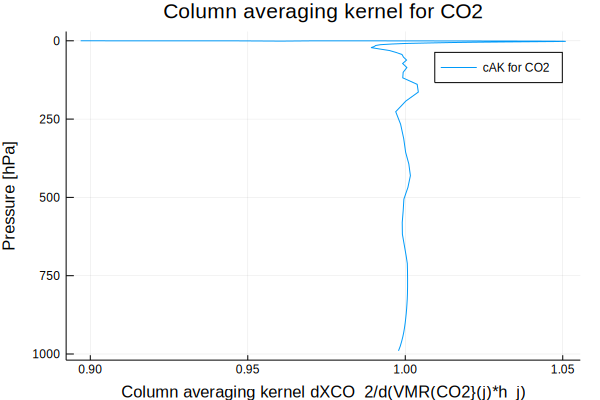

In [158]:
#using PGFPlots
# Compute column kernel:
cK = (transpose(h)*A)[1,:]./h

plot(cK[1:72],p_full, yflip=true, label="cAK for CO2")

xlabel!("Column averaging kernel dXCO_2/d(VMR(CO2}(j)*h_j)")
ylabel!("Pressure [hPa]")
title!("Column averaging kernel for CO2")

---
<font color='red'>**Question:**</font> What does the column averaging kernel represent (in your own words)? 